In [ ]:
####################################################################################################
# Audio-driven upper-body motion synthesis on a humanoid robot
# Computer Science Tripos Part III Project
# Jan Ondras (jo356@cam.ac.uk), Trinity College, University of Cambridge
# 2017/18
####################################################################################################
# Results (tables, plots) from validation of the MLP models (architecture and feature set choice).
####################################################################################################

1_35_AF13
(4,)
	Jerkiness (true) summed:   0.0002416816321335726
Validation over  35 = 5 x 7 parameter settings
1_35_AF26
(4,)
	Jerkiness (true) summed:   0.0002416816321335726
Validation over  35 = 5 x 7 parameter settings
1_35_AF52
(4,)
	Jerkiness (true) summed:   0.0002416816321335726
Validation over  35 = 5 x 7 parameter settings
1_35_AF78
(4,)
	Jerkiness (true) summed:   0.0002416816321335726
Validation over  35 = 5 x 7 parameter settings
MLP_SI VALIDATION: 
(* # training epochs before early stopping)
╒═══════════════╤════════════════════════╤════════════════╤════════════════╤════════════════╕
│ Feature set   │  Best validation loss  │  Optimal # hl  │  Optimal # hu  │  # parameters  │
╞═══════════════╪════════════════════════╪════════════════╪════════════════╪════════════════╡
│ MFCC 13       │        0.018208        │       5        │       8        │      499       │
├───────────────┼────────────────────────┼────────────────┼────────────────┼────────────────┤
│ LogFB 26      │ 

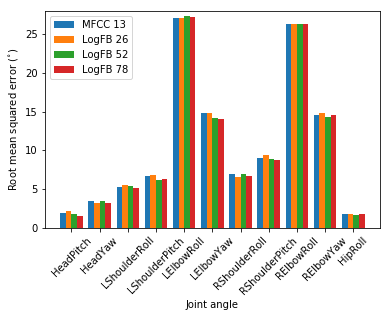

1_35_AF13
0.0001569748749259809
1_35_AF26
0.0001569748749259809
1_35_AF52
0.0001569748749259809
1_35_AF78
0.0001569748749259809
MLP_SD EVALUATION ON VALIDATION SET (averaged over all subjects)
╒═══════════════╤════════════╤═════════╤══════════════╤════════════════╤══════════════╕
│ Feature set   │    Loss    │  RMSE   │  Delta LCCA  │  LCCA (Yt,Yp)  │  Delta jerk  │
╞═══════════════╪════════════╪═════════╪══════════════╪════════════════╪══════════════╡
│ MFCC 13       │ 0.00676616 │ 9.15581 │  0.0299637   │    0.978081    │   80746.3    │
├───────────────┼────────────┼─────────┼──────────────┼────────────────┼──────────────┤
│ LogFB 26      │ 0.00656997 │ 9.02516 │  0.0205042   │    0.978722    │   80565.2    │
├───────────────┼────────────┼─────────┼──────────────┼────────────────┼──────────────┤
│ LogFB 52      │ 0.00702758 │ 9.2498  │  0.0180851   │    0.975926    │   80884.2    │
├───────────────┼────────────┼─────────┼──────────────┼────────────────┼──────────────┤
│ LogFB 78     

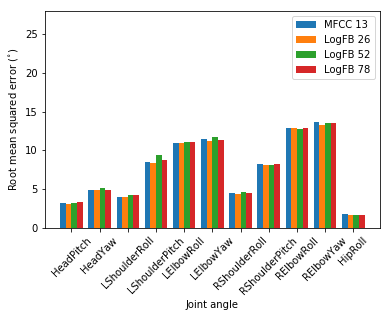

In [5]:
import numpy as np
import time
import glob
import matplotlib.pyplot as plt
from tabulate import tabulate
from evalutils import plot_4RMSE, calculate_norm_delta_jerk_onList

##########################################################################################
# MLP_SI
# Validation
##########################################################################################

N_epochs = [1000, 360, 903, 667]             # when val_loss was minimal

tuning_types = [
    '1_35_AF13',
    '1_35_AF26', 
    '1_35_AF52', 
    '1_35_AF78'
]

N_targets = 11
N_features = np.array([
    13, 26, 52, 78
])
feature_sets = [
    'MFCC 13',
    'LogFB 26', 
    'LogFB 52', 
    'LogFB 78'
]

val_MSE = []
hl  = []
hu = []
N_params = []

RMSE = []
RMSEbyAngles = []
localCCA_XYt = []
localCCA_XYp = []
localCCA_YY = []
jerk = []
jerk_delta = []

losses = []

TE_folder = 'TrainingExamples_16kHz'
save_results_path_prefix = './../Dataset/'+TE_folder+'/Results/MLP_SI/XXX'

for i, tuning_type in enumerate(tuning_types):
    print tuning_type

    # Validation data
    dd = np.load(save_results_path_prefix + 'val_' + tuning_type + '.npz')
    vals = dd['vals']
    vals_std = dd['vals_std']
    best_N_hl = int(dd['best_N_hl'])
    best_N_hu = int(dd['best_N_hu'])
    N_hl_range = dd['N_hl_range']
    N_hu_range = dd['N_hu_range']
    val_MSE.append(np.min(vals))
    hl.append(best_N_hl)
    hu.append(best_N_hu)
    
    # Load results from testing on validation set

    dd = np.load(save_results_path_prefix + 'MSBMvaltest_' + tuning_type + '.npz')

    N_params.append(dd['N_params'])
    #N_epochs.append(dd['N_epochs']) 
    losses.append( np.min(vals) )                     
    
    results_smooth = dd['results_smooth']
    
    RMSE.append( results_smooth[1][0] ) # overall RMSE
    RMSEbyAngles.append( results_smooth[0][0] ) # RMSE by angles
    #print results_smooth[1][0], results_smooth[3]['XYt'][0], results_smooth[4]['pred']
    localCCA_XYt.append( results_smooth[3]['XYt'][0] )
    localCCA_XYp.append( results_smooth[3]['XYp'][0] )
    localCCA_YY.append( results_smooth[3]['YtYp'][0] )
    
    localCCA_delta.append( abs(results_smooth[3]['XYt'][0] - results_smooth[3]['XYp'][0]) )
    
    jerk.append( np.sum( results_smooth[4]['pred'] ) )
    #jerk_delta.append( abs( np.sum( results_smooth[4]['pred'] ) - np.sum( results_smooth[4]['true'] ) ) )
    
    # RECALCULATED JERK !!!
    Y_true_list = dd['Y_true_list']
    Y_pred_list = dd['Y_smooth_list']
    jerk_delta.append( np.sum( calculate_norm_delta_jerk_onList(Y_true_list, Y_pred_list) ) )
    print dd['Y_true_list'].shape

    # CUT RANGE
#     vals = vals[:,:-1]
#     N_hu_range = N_hu_range[:-1]
    print "\tJerkiness (true) summed:  ", np.sum( results_smooth[4]['true'] ) 
    print "Validation over ", len(N_hl_range) * len(N_hu_range), "=", len(N_hl_range), "x", len(N_hu_range), "parameter settings"
    
##### VALIDATION: TUNING ARCH
headers = [
    'Feature set', 
    'Best validation loss', # MSE
    'Optimal # hl',  #'Optimal # hidden layers', 
    'Optimal # hu', #'Optimal # hidden units per layer',
    '# parameters',
    #'# train epochs'
]
# tab_data = np.concatenate(([val_MSE], [hl], [hu], [N_params], [N_epochs]), axis=0).T
tab_data = np.concatenate(([val_MSE], [hl], [hu], [N_params]), axis=0).T
print "MLP_SI VALIDATION: "
print "(* # training epochs before early stopping)"
print tabulate(tab_data, headers=headers, 
               tablefmt='fancy_grid', 
               showindex=feature_sets, 
               numalign='center'
              )
print tabulate(tab_data, headers=headers, 
               tablefmt='latex_booktabs', 
               showindex=feature_sets, 
               numalign='center'
              )

headers = [
    'Feature set', 
    'Loss', 
    'RMSE', 
    'Delta LCCA',
    'LCCA (Yt,Yp)',
    'Delta jerk'
]
tab_data = np.concatenate(([losses], [RMSE], [localCCA_delta], [localCCA_YY], [jerk_delta]), axis=0).T
print "MLP_SI EVALUATION ON VALIDATION SET:"
print tabulate(tab_data, headers=headers, 
               tablefmt='fancy_grid', 
               showindex=feature_sets, 
               numalign='center'
              )
print tabulate(tab_data, headers=headers, 
               tablefmt='latex_booktabs', 
               showindex=feature_sets, 
               numalign='center'
              )

##########################################
# Show bar plot - RMSE by angles
plot_4RMSE(RMSEbyAngles, feature_sets)

##########################################################################################
# MLP_SD
# Evaluation on validation set
##########################################################################################

save_results_path_prefix = './../Dataset/'+TE_folder+'/Results/MLP_SD/XXX'

unique_srt_VIDs = np.load('./../Dataset/'+TE_folder+'/te_unique_srt_VIDs.npz')['unique_srt_VIDs']
unique_srt_SIDs = np.array([x[:5] for i, x in enumerate(unique_srt_VIDs) if i % 2 == 0]) # ['PID02', 'PID05', ..

RMSE = []
RMSEbyAngles = []
localCCA_XYt = []
localCCA_XYp = []
localCCA_YY = []
jerk = []
jerk_delta = []
localCCA_delta = []
lossesMean = []

for i, tuning_type in enumerate(tuning_types):
    print tuning_type
    
    rmse_overall_list = []
    rmse_byAngles_list = []
    local_cca_YtYp = [] 
    local_cca_XYt = [] 
    local_cca_XYp = [] 
    jerkiness_true = []
    jerkiness_pred = []
    jerkiness_delta_perSID = []
    losses = []

    for s, SID in enumerate(unique_srt_SIDs):

        #print SID
        # Load results from testing on validation set
        d = np.load(save_results_path_prefix + 'MSBMvaltest_' + SID + '_' + tuning_type + '.npz')

        local_cca_YtYp.append( d['results_smooth'][3]['YtYp'] ) # with stds
        local_cca_XYt.append( d['results_smooth'][3]['XYt'] )
        local_cca_XYp.append( d['results_smooth'][3]['XYp'] )
        #print d['results_smooth'][3]['YtYp']
        rmse_overall_list.append( d['results_smooth'][1][0] ) # take only means, not stds
        rmse_byAngles_list.append( d['results_smooth'][0][0] )

        jerkiness_true.append( np.sum(d['results_smooth'][4]['true']) )
        jerkiness_pred.append( np.sum(d['results_smooth'][4]['pred']) )
        #jerkiness_delta_perSID.append( abs( np.sum(d['results_smooth'][4]['true']) - np.sum(d['results_smooth'][4]['pred']) ) )

        # RECALCULATED JERK
        Y_true_list = d['Y_true_list']
        Y_pred_list = d['Y_smooth_list']
        jerkiness_delta_perSID.append( np.sum( calculate_norm_delta_jerk_onList(Y_true_list, Y_pred_list) ) )
        
        losses.append( d['test_loss'] )
    
    RMSE.append( np.mean(rmse_overall_list, axis=0) ) # overall RMSE
    RMSEbyAngles.append( np.mean(rmse_byAngles_list, axis=0) )
    #print results_smooth[1][0], results_smooth[3]['XYt'][0], results_smooth[4]['pred']
    localCCA_XYt.append( np.mean(local_cca_XYt, axis=0)[0] )
    localCCA_XYp.append( np.mean(local_cca_XYp, axis=0)[0] )
    localCCA_YY.append( np.mean(local_cca_YtYp, axis=0)[0] )
    
    localCCA_delta.append( abs( np.mean(local_cca_XYt, axis=0)[0] - np.mean(local_cca_XYp, axis=0)[0] ) )
    
    jerk.append( np.mean(jerkiness_pred, axis=0) )
    jerk_delta.append( np.mean(jerkiness_delta_perSID, axis=0) )
    print np.mean(jerkiness_true, axis=0)

    lossesMean.append( np.mean(losses) )                      

########################################################################################
headers = [
    'Feature set', 
    'Loss', 
    'RMSE', 
    'Delta LCCA',
    'LCCA (Yt,Yp)',
    'Delta jerk'
]
tab_data = np.concatenate(([lossesMean], [RMSE], [localCCA_delta], [localCCA_YY], [jerk_delta]), axis=0).T
print "MLP_SD EVALUATION ON VALIDATION SET (averaged over all subjects)"
print tabulate(tab_data, headers=headers, 
               tablefmt='fancy_grid', 
               showindex=feature_sets, 
               numalign='center'
              )

##########################################
# Show bar plot - RMSE by angles
plot_4RMSE(RMSEbyAngles, feature_sets)